In [1]:
import os
import sys
import pickle

PROJECT_ROOT = os.path.abspath('..')
sys.path.append(PROJECT_ROOT)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sleeprnn.helpers.reader import load_dataset
from sleeprnn.common import constants, viz, pkeys
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection.predicted_dataset import PredictedDataset
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import det_utils
from figs_thesis import fig_utils

viz.notebook_full_width()

RESULTS_PATH = os.path.join(PROJECT_ROOT, 'results')

/home/ntapia/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Max amplitude preliminaries

In [ ]:
mass = load_dataset('mass_kc')
signals = mass.get_signals(normalize_clip=False)
marks = mass.get_stamps(pages_subset='n2')

In [ ]:
all_kc_min = []
all_kc_max = []
for sub_signal, sub_marks in zip(signals, marks):
    kc = [sub_signal[m[0]:m[1]+1] for m in sub_marks]
    kc_min = np.array([np.min(s) for s in kc])
    kc_max = np.array([np.max(s) for s in kc])
    all_kc_min.append(kc_min)
    all_kc_max.append(kc_max)
all_kc_min = np.concatenate(all_kc_min)
all_kc_max = np.concatenate(all_kc_max)
print(all_kc_min.shape, all_kc_max.shape)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=100)
ax = axes[0]
ax.hist(all_kc_min)
ax.set_title("Neg Peak")
ax = axes[1]
ax.hist(all_kc_max)
ax.set_title("Pos Peak")
plt.tight_layout()
plt.show()

prct = 98

print("Negative Peak prct %d: %1.4f uV" % (prct, np.percentile(all_kc_min, 100-prct)))
print("Positive Peak prct %d: %1.4f uV" % (prct, np.percentile(all_kc_max, prct)))

# NSRR EXPLORATION

In [2]:
class PredictedNSRR(object):
    def __init__(
        self,
        experiment_folder='20210716_from_20210529_thesis_indata_5cv_e1_n2_train_moda_ss_ensemble_to_e1_n2_train_nsrr_ss',
        grid_folder='v2_time',
        page_duration=30,
        min_separation=0.3,
        min_duration=0.3,
        max_duration=3.0,
        repair_long_detections=False,
    ):
        self.experiment_folder = experiment_folder
        self.grid_folder = grid_folder
        self.subject_to_fold_map = self._hash_predictions()
        self.all_ids = np.sort(list(self.subject_to_fold_map.keys()))        
        self.post_params = {
            pkeys.PAGE_DURATION: page_duration,
            pkeys.SS_MIN_SEPARATION: min_separation,
            pkeys.SS_MIN_DURATION: min_duration,
            pkeys.SS_MAX_DURATION: max_duration,
            pkeys.REPAIR_LONG_DETECTIONS: repair_long_detections,
        }

    def get_predictions(self, fold_ids_list, dataset, threshold=0.5):
        proba_dict = {}
        for fold_id in fold_ids_list:
            t_proba_dict = self.get_fold_probabilities(fold_id)
            proba_dict.update(t_proba_dict)
        subject_ids = list(proba_dict.keys())
        subject_ids.sort()
        feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=1)
        feed_d.unknown_id = dataset.unknown_id
        feed_d.n2_id = dataset.n2_id
        feed_d.original_page_duration = dataset.original_page_duration
        prediction = PredictedDataset(
            dataset=feed_d,
            probabilities_dict=proba_dict,
            params=self.post_params.copy(), skip_setting_threshold=True)
        prediction.set_probability_threshold(threshold)
        return prediction
        
    def get_subject_fold(self, subject_id):
        return self.subject_to_fold_map[subject_id]
    
    def get_fold_probabilities(self, fold_id):
        pred_path = os.path.join(RESULTS_PATH, 'predictions_nsrr_ss', self.experiment_folder, self.grid_folder)
        fold_path = os.path.join(pred_path, 'fold%d' % fold_id, 'prediction_n2_test.pkl')
        with open(fold_path, 'rb') as handle:
            proba_dict = pickle.load(handle)
        return proba_dict
    
    def _hash_predictions(self):
        pred_path = os.path.join(RESULTS_PATH, 'predictions_nsrr_ss', self.experiment_folder, self.grid_folder)
        folds = os.listdir(pred_path)
        folds = [int(f.split("fold")[-1]) for f in folds]
        folds = np.sort(folds)
        
        subject_to_fold_map = {}
        for fold_id in folds:
            proba_dict = self.get_fold_probabilities(fold_id)
            fold_subjects = list(proba_dict.keys())
            for subject_id in fold_subjects:
                subject_to_fold_map[subject_id] = fold_id
        return subject_to_fold_map

In [3]:
nsrr_preds = PredictedNSRR()

In [4]:
nsrr = load_dataset(constants.NSRR_SS_NAME, load_checkpoint=True)

Dataset nsrr_ss with 3 patients.
Loading from checkpoint... Loaded
Global STD: None
Dataset nsrr_ss with 11593 patients.


# Reproducción de tendencias

In [5]:
n_folds = 10
threshold = 0.5

fold_ids_list = np.arange(n_folds)
predictions = nsrr_preds.get_predictions(fold_ids_list, nsrr, threshold=threshold)

print("Loaded predictions for %d subjects with threshold %1.2f" % (len(predictions.all_ids), threshold))

Loaded predictions for 1000 subjects with threshold 0.50


In [6]:
min_n2_minutes = 60

subject_ids = predictions.all_ids

table_byevent = {'duration': []}
table_bysubject = {
    'subject_id': [], 
    'duration': [], 'density': [], 'proba_event': [], 
    'n2_minutes': [], 'origin': [],
    'age': [], 'female': [],
}
for i in range(len(subject_ids)):
    subject_id = subject_ids[i]
    n2_pages = predictions.data[subject_id]['n2_pages']
    n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
    
    if n2_minutes < min_n2_minutes:
        print("Skipped by N2 minutes: Subject %s with %d N2 minutes" % (subject_id, n2_minutes))
        continue
    
    marks = predictions.get_subject_stamps(subject_id)
    n_marks = marks.shape[0]
    
    if n_marks == 0:
        print("Skipped by Marks     : Subject %s with %d marks (%d N2 minutes)" % (subject_id, n_marks, n2_minutes))
        continue

    durations = (marks[:, 1] - marks[:, 0] + 1) / nsrr.fs
    subject_proba = predictions.get_subject_stamps_probabilities(subject_id)
    
    subject_mean_duration = np.mean(durations)
    subject_density = n_marks / n2_minutes
    subject_mean_proba = np.mean(subject_proba)
    subdataset = subject_id[:-4]
    
    subject_data = nsrr.read_subject_data(subject_id)
    age = float(subject_data['age'].item())
    female = int(subject_data['sex'].item() == 'f')
    
    table_byevent['duration'].append(durations)
    table_bysubject['subject_id'].append(subject_id)
    table_bysubject['duration'].append(subject_mean_duration)
    table_bysubject['density'].append(subject_density)
    table_bysubject['proba_event'].append(subject_mean_proba)
    table_bysubject['n2_minutes'].append(n2_minutes)
    table_bysubject['origin'].append(subdataset)
    table_bysubject['age'].append(age)
    table_bysubject['female'].append(female)
    
for key in table_byevent:
    table_byevent[key] = np.concatenate(table_byevent[key])
table_byevent = pd.DataFrame.from_dict(table_byevent)
table_bysubject = pd.DataFrame.from_dict(table_bysubject)
print("Done.")

Skipped by N2 minutes: Subject cfs-visit5-800393 with 27 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-300365 with 2 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-301091 with 36 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-301108 with 57 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-nonrandomized-300521 with 0 N2 minutes
Skipped by N2 minutes: Subject chat-baseline-nonrandomized-300607 with 0 N2 minutes
Skipped by N2 minutes: Subject mros-visit1-aa0965 with 18 N2 minutes
Skipped by N2 minutes: Subject mros-visit1-aa5622 with 13 N2 minutes
Skipped by N2 minutes: Subject shhs1-200489 with 24 N2 minutes
Skipped by N2 minutes: Subject shhs1-201788 with 28 N2 minutes
Skipped by N2 minutes: Subject shhs1-202005 with 31 N2 minutes
Skipped by N2 minutes: Subject shhs1-202274 with 59 N2 minutes
Skipped by N2 minutes: Subject shhs1-202418 with 35 N2 minutes
Skipped by N2 minutes: Subject shhs1-202444 with 37 N2 minutes
Skipped by Marks     : Subject shhs1

In [7]:
table_byevent

,duration
0,0.44
1,0.72
2,1.48
3,0.60
4,0.64
...,...
213296,0.40
213297,0.68
213298,0.36
213299,0.84


In [8]:
table_bysubject

,subject_id,duration,density,proba_event,n2_minutes,origin,age,female
0,ccshs-trec-1800034,1.121019,5.009119,0.925283,164.5,ccshs-trec-180,17.40,1
1,ccshs-trec-1800038,1.105720,4.438356,0.885380,219.0,ccshs-trec-180,17.40,1
2,ccshs-trec-1800065,0.955523,3.031250,0.883508,224.0,ccshs-trec-180,17.68,1
3,ccshs-trec-1800074,0.874167,2.909091,0.874492,214.5,ccshs-trec-180,17.86,1
4,ccshs-trec-1800078,0.834557,2.638831,0.855022,239.5,ccshs-trec-180,17.77,0
...,...,...,...,...,...,...,...,...
977,sof-visit-8-09018,0.732103,1.315534,0.872237,206.0,sof-visit-8-0,81.00,1
978,sof-visit-8-09036,0.728224,0.924406,0.849786,231.5,sof-visit-8-0,81.00,1
979,sof-visit-8-09614,0.971579,0.795812,0.703575,95.5,sof-visit-8-0,83.00,1
980,sof-visit-8-09627,0.698621,1.059361,0.787899,109.5,sof-visit-8-0,82.00,1


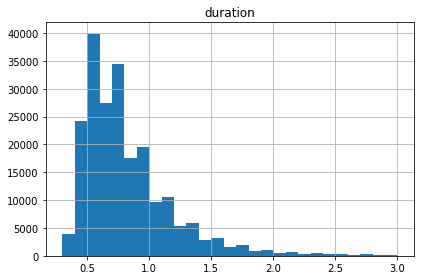

In [9]:
# by-event stuff
table_byevent.hist(bins=np.arange(0.3, 3.0 + 0.001, 0.1))
plt.tight_layout()
plt.show()

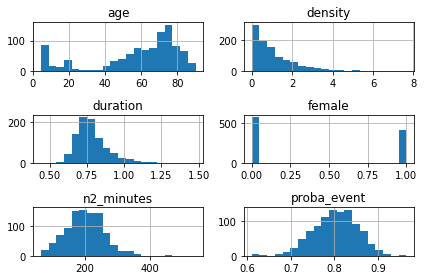

In [10]:
table_bysubject.hist(bins=20)
plt.tight_layout()
plt.show()

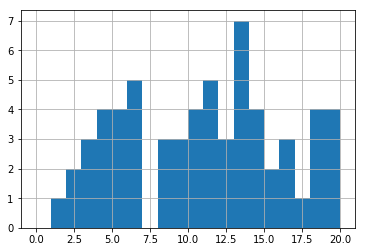

1.0


In [11]:
a = (table_bysubject['n2_minutes'] * table_bysubject['density'])
a[a <= 20].hist(bins=np.arange(0, 20 + 0.001, 1))
plt.show()
print(a.min())

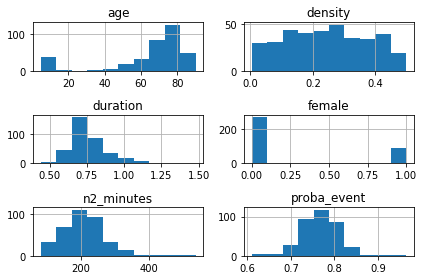

In [12]:
zoom_density = 0.5

table_zoom = table_bysubject[table_bysubject.density < zoom_density]
table_zoom.hist()
plt.tight_layout()
plt.show()

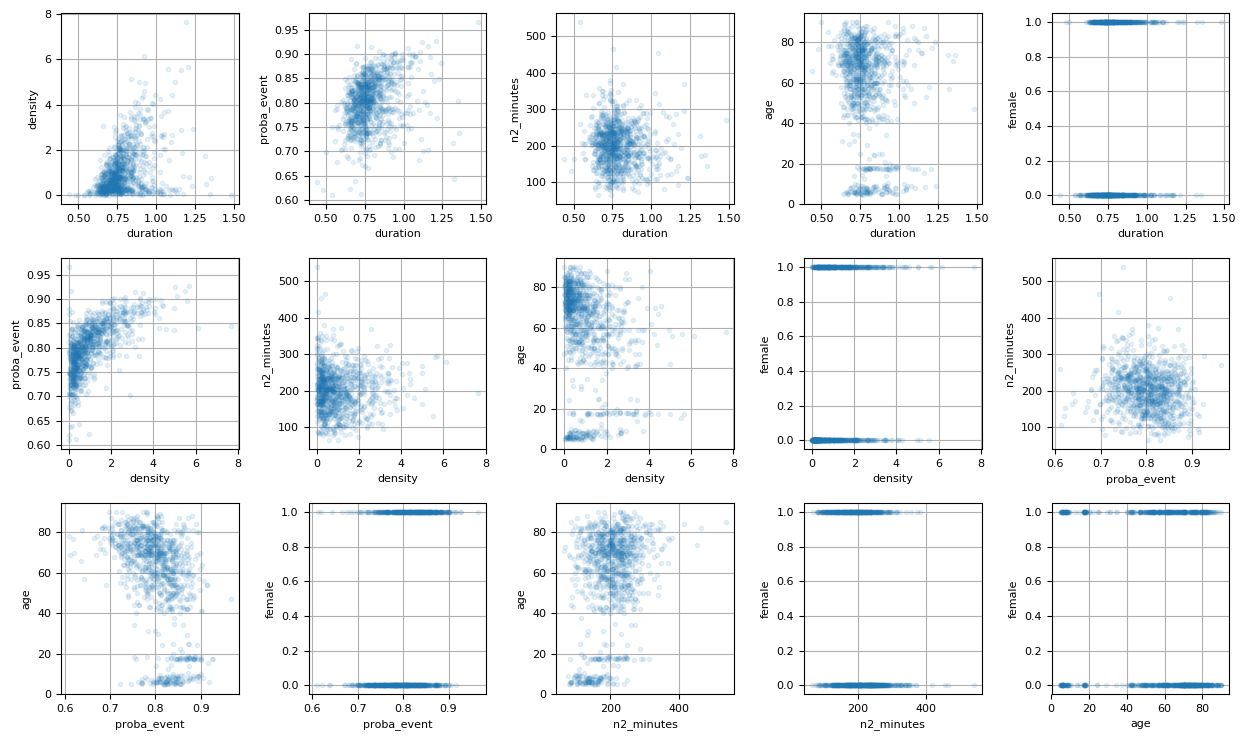

In [13]:
# correlations

param_names = table_bysubject.select_dtypes(include=np.number).columns.tolist()
n_params = len(param_names)
n_plots = n_params * (n_params - 1) / 2
n_cols = 5
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows* 2.5), dpi=100)
axes = axes.flatten()
global_count = -1
for i in range(n_params):
    for j in range(i + 1, n_params):
        global_count += 1
        ax = axes[global_count]
        
        x_data = table_bysubject[param_names[i]].values
        y_data = table_bysubject[param_names[j]].values
        
        ax.plot(x_data, y_data, linestyle="none", marker='o', markersize=3, alpha=0.1)
        ax.set_xlabel(param_names[i], fontsize=8)
        ax.set_ylabel(param_names[j], fontsize=8)
        
        ax.tick_params(labelsize=8)
        ax.grid()
plt.tight_layout()
plt.show()

In [14]:
table_bysubject[table_bysubject.duration > 1.2]

,subject_id,duration,density,proba_event,n2_minutes,origin,age,female
14,ccshs-trec-1800322,1.208157,5.684746,0.926404,295.0,ccshs-trec-180,17.42,1
166,chat-baseline-nonrandomized-300709,1.237407,2.918919,0.881910,111.0,chat-baseline-nonrandomized-30,8.80,1
200,mros-visit1-aa0121,1.314660,1.741228,0.716969,228.0,mros-visit1-aa,74.00,0
337,mros-visit1-aa3470,1.346667,0.034483,0.803385,174.0,mros-visit1-aa,71.00,0
532,shhs1-201228,1.229787,0.421525,0.847463,111.5,shhs1-20,80.00,1
538,shhs1-201274,1.357455,0.758621,0.736506,145.0,shhs1-20,74.00,1
561,shhs1-201523,1.211586,0.785908,0.768129,369.0,shhs1-20,77.00,0
574,shhs1-201581,1.480000,0.011029,0.965332,272.0,shhs1-20,47.00,1
909,shhs1-205404,1.321395,0.500000,0.643717,172.0,shhs1-20,57.00,1


# Check stats of all pages

In [15]:
spectra = []
all_std = []
large_subjects = []
for subject_id in predictions.all_ids:
    signal = nsrr.get_subject_signal(subject_id, normalize_clip=False)
    n2_pages = predictions.data[subject_id]['n2_pages']
    n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
    
    if n2_minutes < 60:
        continue
    
    x_pages = signal.reshape(-1, nsrr.original_page_duration * nsrr.fs)[n2_pages]
    for i_n2, x in enumerate(x_pages):
        freq, power = utils.power_spectrum_by_sliding_window(x, nsrr.fs, window_duration=2)
        spectra.append(power)
        this_std = x.std()
        all_std.append(this_std)
        if this_std > 50:
            large_subjects.append(subject_id)
spectra = np.stack(spectra, axis=0)
all_std = np.array(all_std)
large_subjects = np.unique(large_subjects)
print("Done")
print(spectra.shape, all_std.shape, large_subjects.shape)

Done
(396666, 201) (396666,) (131,)


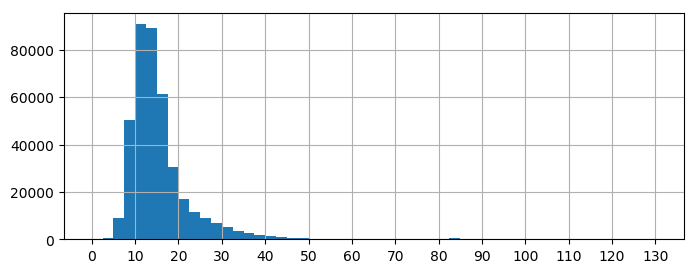

STD -- Min 0.1933, Mean 15.8058, Median 13.7657, Max 121.4612
STD -- Percentile 0.5: 6.1452
STD -- Percentile 99.5: 73.3358
3642 396666 0.9181528036181573


In [35]:
# std hist
fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=100)
ax.hist(all_std, bins=np.arange(0, 130 + 0.001, 2.5))
ax.set_xticks(np.arange(0, 130 + 0.001, 10))
ax.grid()
plt.show()

print("STD -- Min %1.4f, Mean %1.4f, Median %1.4f, Max %1.4f" % (all_std.min(), all_std.mean(), np.median(all_std), all_std.max()))

# Central 95% of pages
# STD between 7.5 and 36.

prctl = 0.5
print("STD -- Percentile %s: %1.4f" % (prctl, np.percentile(all_std, prctl)))

prctl = 99.5
print("STD -- Percentile %s: %1.4f" % (prctl, np.percentile(all_std, prctl)))
print(np.sum(all_std > 50), all_std.size, 100 * np.sum(all_std > 50)/all_std.size)

In [ ]:
valid_locs = np.where((freq >= 0.3) & (freq <= 30))[0]
freq_short = freq[valid_locs]
spectra_short = spectra[:, valid_locs]

fig, axes = plt.subplots(1, 2, figsize=(6, 2), dpi=100)

ax = axes[0]
ax.plot(freq_short, spectra_short.mean(axis=0))
ax.set_xlim([0.1, 35])
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)

ax = axes[1]
ax.plot(freq_short, spectra_short.mean(axis=0))
ax.set_xlim([0.1, 35])
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)
plt.tight_layout()
plt.show()

# Check single subject

subject ccshs-trec-1800294
Marks (172, 2)
N2 minutes 155.0


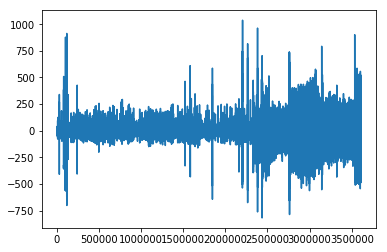

Center samples where STD is greater than 50.0000
[2643000 2655000 2691000 2697000 2727000 2751000]
[57.460396 56.32024  61.18277  61.813473 55.648663 58.86516 ]


In [38]:
subject_id = large_subjects[1]   # 'shhs1-201711'  # 'sof-visit-8-02332'

print("subject %s" % subject_id)
subject_data = nsrr.read_subject_data(subject_id)
signal = subject_data['signal']
n2_pages = subject_data['n2_pages']
n2_minutes = n2_pages.size * nsrr.original_page_duration / 60
marks = predictions.get_subject_stamps(subject_id, pages_subset='n2')
proba = predictions.get_subject_probabilities(subject_id)
proba_up = np.repeat(proba, 8)
durations = (marks[:, 1] - marks[:, 0] + 1) / nsrr.fs

print("Marks", marks.shape)
print("N2 minutes", n2_minutes)

plt.plot(signal)
plt.show()

std_to_find = 50

x_pages_std = signal.reshape(-1, nsrr.original_page_duration * nsrr.fs)[n2_pages].std(axis=1)
n2_pages_locs = np.where(x_pages_std > std_to_find)[0]
std_selected = x_pages_std[n2_pages_locs]
pages_locs = n2_pages[n2_pages_locs]
start_sample = pages_locs * nsrr.original_page_duration * nsrr.fs
center_sample = start_sample + nsrr.original_page_duration * nsrr.fs // 2
print("Center samples where STD is greater than %1.4f" % std_to_find)
print(center_sample)
print(std_selected)

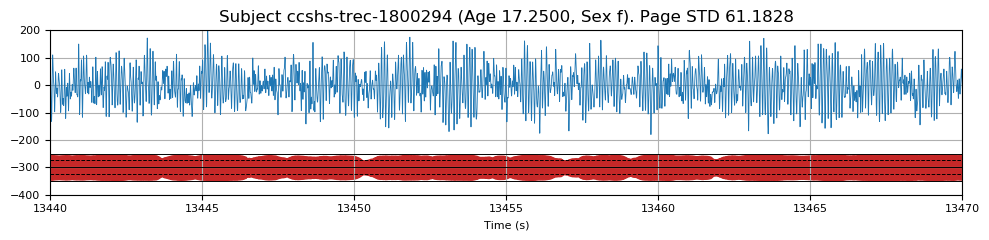

Page STD: 61.1828


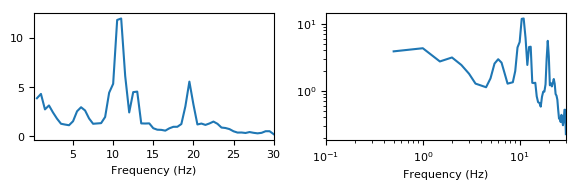

In [41]:
# mark_selected = marks[5]

center_sample = 2691000 # mark_selected.mean()

window_duration = 30
window_size = nsrr.fs * window_duration
start_sample = int(center_sample - window_size // 2)
end_sample = int(start_sample + window_size)
time_axis = np.arange(start_sample, end_sample) / nsrr.fs

fig, ax = plt.subplots(1, 1, figsize=(10, 2.5), dpi=100)

ax.plot(time_axis, signal[start_sample:end_sample], linewidth=.6)

# ax.plot(mark_selected / nsrr.fs, [-100, -100], linewidth=4, color=viz.PALETTE['red'], alpha=0.7)

ax.fill_between(
    time_axis, 
    -300 - 50 * proba_up[start_sample:end_sample], 
    -300 + 50 * proba_up[start_sample:end_sample],
    color=viz.PALETTE['red'], alpha=1.0
)
ax.axhline(-300 - 50, linewidth=0.7, linestyle="-", color="k")
ax.axhline(-300 + 50, linewidth=0.7, linestyle="-", color="k")
ax.axhline(-300 - 25, linewidth=0.7, linestyle="--", color="k")
ax.axhline(-300 + 25, linewidth=0.7, linestyle="--", color="k")
ax.axhline(-300 + 0, linewidth=0.7, linestyle="-", color="k")

ax.set_ylim([-400, 200])
ax.set_xlim([start_sample/nsrr.fs, end_sample/nsrr.fs])

ax.grid()
ax.set_xlabel("Time (s)", fontsize=8)
ax.tick_params(labelsize=8)

page_std = signal[start_sample:end_sample].std()

ax.set_title("Subject %s (Age %1.4f, Sex %s). Page STD %1.4f" % (
    subject_id, subject_data['age'], subject_data['sex'], page_std
))

plt.tight_layout()
plt.show()

print("Page STD: %1.4f" % page_std)

# Compute spectrum of page
freq, power = utils.power_spectrum_by_sliding_window(signal[start_sample:end_sample], nsrr.fs, window_duration=2)
valid_locs = np.where((freq >= 0.3) & (freq <= 30))[0]
freq = freq[valid_locs]
power = power[valid_locs]

fig, axes = plt.subplots(1, 2, figsize=(6, 2), dpi=100)

ax = axes[0]
ax.plot(freq, power)
ax.set_xlim([0.1, 30])
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)

ax = axes[1]
ax.plot(freq, power)
ax.set_xlim([0.1, 30])
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(labelsize=8)
ax.set_xlabel("Frequency (Hz)", fontsize=8)
plt.tight_layout()
plt.show()